In [1]:
%reset -f

import pandas as pd
import numpy as np
import scipy as sci
import sympy as sym
import math
import networkx as nx
import matplotlib.pyplot as plt
import time
import gurobipy as gp
import igraph as ig
import pickle


from numpy import sqrt, exp, log, sin, cos, pi, polyfit, polyval, vander
from numpy.linalg import inv, pinv, det, matrix_rank, cond, lstsq, solve
from scipy.integrate import solve_ivp
from gurobipy import GRB
from itertools import combinations
from pyinstrument import Profiler
from numba import jit

plt.style.use('default')                                    # 使用默认风格
plt.rcParams['figure.facecolor'] = 'white'                  # 将图形的背景颜色设置为白色
plt.rcParams['font.family'] = 'YaHei Consolas Hybrid'       # 字体确认
plt.rcParams['font.size'] = 12                              # 字体大小
plt.rcParams['axes.unicode_minus'] = False                  # 正常显示负号
%matplotlib inline
#matplotlib.use('TkAgg')

# 点总数
nodecnts = 130
# 喷水车数目
carcnts = 20
# 名称--点序号
node_number = {}
# 点序号--坐标
num2pos = {}
# 边的信息
edgeInfo = np.zeros((nodecnts, nodecnts))
# 停靠点数目
stopNodes = 2
# 工作点数目
workingNodes = 0
working_map = {}
# 给水点数目
waterNodes = 0
water_map = {}
# 正常点的数目
normalNodes = 0
normal_map = {}
# A车、B车在1级路的速度
speed1 = (60, 50)
# A车、B车在2级路的速度       
speed2 = (45, 30)
# A车、B车的作业时间
workingcost = (1/3, 1/4)
# 构建花费矩阵
# fullcostmat[0][][]是A车的时间花费矩阵,fullcostmat[1][][]是B车的
fullcostmat = np.zeros((2, nodecnts, nodecnts))
# 0--D1  1--D2
car_start = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
# 0--A  1--B
car_category = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [2]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
def dis(p1: Point, p2: Point):
    return ((p2.x - p1.x)**2 + (p2.y - p1.y)**2)**0.5

with open('节点信息.txt','r') as file:
    for line in file:
        line = line.strip()
        if line:
            node_data = line.split('\t')
            node_name = node_data[0]
            x = float(node_data[1])
            y = float(node_data[2])
            num = int(node_data[3])
            p = Point(x, y)
            node_number[node_name] = num
            node_number[num] = node_name
            num2pos[num] = p
            # 按照点的分类，给每一类点的重新编号对应着原始的编号
            if node_name[0] == 'Z':
                water_map[waterNodes] = num
                waterNodes += 1
            elif node_name[0] == 'F':
                working_map[workingNodes] = num
                workingNodes += 1
            elif node_name[0] == 'J':
                normal_map[normalNodes] = num
                normalNodes += 1

# 添加两个额外点作为终点和对应的映射
node_number[nodecnts] = 'D1'
node_number[nodecnts + 1] = 'D2'

            
with open('连通情况.txt','r') as file:
    for line in file:
        line = line.strip()
        if line:
            edge_data = line.split(' ')
            N1 = node_number[edge_data[0]]
            N2 = node_number[edge_data[1]]
            edgeInfo[N1][N2] = edgeInfo[N2][N1] = edge_data[2]

# 构建花费矩阵
# 计算A、B车时间花费矩阵
for c in range(2):
    for i in range(nodecnts):
        for j in range(nodecnts):
            if edgeInfo[i][j] == 0:
                fullcostmat[c][i][j] = np.inf
            elif edgeInfo[i][j] == 1:
                d = dis(num2pos[i], num2pos[j])
                fullcostmat[c][i][j] = d / speed1[c]
            elif edgeInfo[i][j] == 2:
                d = dis(num2pos[i], num2pos[j])
                fullcostmat[c][i][j] = d / speed2[c]

# 最短路与矩阵切割

@jit(nopython=True)
def Floyd(costmat):
    # Floyd跑一波得到点到点的最短路
    for c in range(2):
        for k in range(nodecnts):
            for i in range(nodecnts):
                for j in range(nodecnts):
                    if i == j:
                        continue
                    costmat[c][i][j] = min(costmat[c][i][j], 
                        costmat[c][i][k] + costmat[c][k][j]
                        )
    return costmat

fullcostmat = Floyd(fullcostmat)

# 取前2 + 6 + 60 + 2个点即停靠点+给水点+作业点+两个虚拟的停靠点作为终点
costmat = fullcostmat[::, :70, :70]

for i in range(2):
    # 前两列复制到后两列
    costmat[i][:, -2:] = costmat[i][:, :2]
    # 前两行复制到后两行
    costmat[i][-2:, :] = costmat[i][:2, :]
    

# 绘图

def draw_graph():
    g = ig.Graph()

    # 添加点
    g.add_vertices(nodecnts)
    g.vs["x"] = [num2pos[i].x for i in range(nodecnts)]
    g.vs["y"] = [num2pos[i].y for i in range(nodecnts)]
    g.vs["label"] = [node_number[i] for i in range(nodecnts)]
    g.vs["label_size"] = [9 if node_number[i][0] == "Z" else
                    10 if node_number[i][0] == "F" else
                    9 if node_number[i][0] == "J" else
                    11 for i in range(nodecnts)]
    g.vs["size"] = [7.5 if node_number[i][0] == "Z" else
                    6 if node_number[i][0] == "F" else
                    5 if node_number[i][0] == "J" else
                    6 for i in range(nodecnts)]
    g.vs["color"] = ["#0070FF" if node_number[i][0] == "Z" else
                    "#FFFEA4" if node_number[i][0] == "F" else
                    "gray" if node_number[i][0] == "J" else
                    "#00DDFF" for i in range(nodecnts)]
    g.vs["shape"] = ["diamond" if node_number[i][0] == "Z" else
                    "circle" if node_number[i][0] == "F" else
                    "circle" if node_number[i][0] == "J" else
                    "rectangle" for i in range(nodecnts)]

    # 添加边
    # 根据costmat[0]添加边（只添加单条边）
    for i in range(nodecnts):
        for j in range(i+1, nodecnts):
            if edgeInfo[i][j] == 1:
                g.add_edge(i, j, weight=fullcostmat[0][i][j], color="red")
            elif edgeInfo[i][j] == 2:
                g.add_edge(i, j, weight=fullcostmat[0][i][j], color="black")
    return g


In [3]:
## 对工艺矩阵施加误差

# 误差强度上限
min_err = 0
max_err = 0.1
N = len(costmat[0])

changeCostAopt = []
changeCostBopt = []
for beta in np.arange(min_err, max_err, 0.001):
    print(f"beta:{beta}")
    err_costmat= np.zeros_like(costmat)
    err1 = 1-beta + (1+beta - (1-beta)) * np.random.random(size=(N, N))
    err_costmat[0] = costmat[0] * err1
    err2 = 1-beta + (1+beta - (1-beta)) * np.random.random(size=(N, N))
    err_costmat[1] = costmat[1] * err2

    err_workingcost = workingcost
    
    ## 第二问线性规划

    # 创建优化问题
    prob2 = gp.Model('喷洒车作业优化Q2')
    # 创建优化变量
    x1 = prob2.addVars(carcnts, workingNodes, waterNodes, vtype=GRB.BINARY, name='workingState1')
    x2 = prob2.addVars(carcnts, waterNodes, workingNodes, waterNodes, vtype=GRB.BINARY, name='workingState2')
    t = prob2.addVars(carcnts, vtype=GRB.CONTINUOUS, name='cost') 
    tmax = prob2.addVar(vtype=GRB.CONTINUOUS, name='maxcost')

    # 每个喷洒车必须作业两次
    for i in range(carcnts):
        prob2.addConstr(gp.quicksum(x1[i, j1, k1] 
                                    for j1 in range(workingNodes) for k1 in range(waterNodes)) == 1)
        prob2.addConstr(gp.quicksum(x2[i, k1, j2, k2] 
                                    for k1 in range(waterNodes) for j2 in range(workingNodes) for k2 in range(waterNodes)) == 1)
        for k1 in range(waterNodes):
            prob2.addConstr(gp.quicksum(x1[i, j1, k1] for j1 in range(workingNodes)) == 
                            gp.quicksum(x2[i, k1, j2, k2] for j2 in range(workingNodes) for k2 in range(waterNodes)))

    # 每个作业点最多作业1次
    for j in range(workingNodes):
        prob2.addConstr(gp.quicksum(x1[i, j, k1] for i in range(carcnts) for k1 in range(waterNodes)) + 
                        gp.quicksum(x2[i, k1, j, k2] 
                                    for i in range(carcnts) for k1 in range(waterNodes) for k2 in range(waterNodes)) <= 1)
        
    # 单个给水点最多加8次水
    for k in range(waterNodes):
        prob2.addConstr(gp.quicksum((x2[i, k, j, kk] + x2[i, kk, j, k]) 
                                    for i in range(carcnts) for j in range(workingNodes) for kk in range(waterNodes)) <= 8)
        
    # 计算每一个洒水车的用时
    for i in range(carcnts):
        # 对于每一辆车
        cg = car_category[i]
        sp = car_start[i]
        # 第一阶段耗时
        expr1 = gp.quicksum(x1[i, j1, k1] * 
                            (err_costmat[cg][sp][working_map[j1]] + err_costmat[cg][working_map[j1]][water_map[k1]] + err_workingcost[cg]) 
                            for j1 in range(workingNodes) for k1 in range(waterNodes))
        # 第二阶段耗时
        expr2 = gp.quicksum(x2[i, k1, j2, k2] * 
                            (err_costmat[cg][water_map[k1]][working_map[j2]] + err_costmat[cg][working_map[j2]][water_map[k2]] + err_workingcost[cg]) 
                            for k1 in range(waterNodes) for j2 in range(workingNodes) for k2 in range(waterNodes))
        
        prob2.addConstr(t[i] == expr1 + expr2)

    # 求最长用时的车
    prob2.addConstrs(tmax >= t[i] for i in range(carcnts))

    # 目标函数
    prob2.setObjectiveN(tmax, priority=1, index=0)
    prob2.setObjectiveN(t.sum(), priority=0, index=1)

    # 求解参数
    prob2.setParam('OutputFlag', 0)
    prob2.Params.MIPFocus=0
    prob2.Params.Presolve=-1

    prob2.optimize()
    
    changeCostAopt.append(max([t[i].x for i in range(carcnts) if car_category[i] == 0]))
    changeCostBopt.append(max([t[i].x for i in range(carcnts) if car_category[i] == 1]))
    print(changeCostAopt)
    print(changeCostBopt)




beta:0.0


In [4]:
changeCostAopt = [6.68685090941695, 6.688618821984426, 6.683933389250496, 6.6821842280356245, 6.668014894830515, 6.693014200789759, 6.692736496590148, 6.685498462253401, 6.688990241873128, 6.680465025427544, 6.689061215883223, 6.68162003992185, 6.659051773567619, 6.662180377244309, 6.712511041026373, 6.649855081595858, 6.646809263568644, 6.684474586185472, 6.688056558784045, 6.727909722192892, 6.693065545459072, 6.661928351856754, 6.638480747203392, 6.678540753397137, 6.574197611728569, 6.644043243512631, 6.673691638547323, 6.642046210571191, 6.649154908277787, 6.66021540987081, 6.659772139114668, 6.6394686592660905, 6.690993152796208, 6.6868905120834565, 6.662297489457122, 6.630215477091181, 6.698684688300829, 6.638195090129445, 6.67618155283208, 6.62977074442119, 6.629297297076395, 6.7075326706479, 6.601669761180447, 6.592116020726092, 6.612510678588462, 6.651041206597956, 6.683901512125823, 6.647545984683154, 6.598833285863577, 6.52243514079175, 6.505316168957411, 6.4534327535308265, 6.604887329820626, 6.623673942962544, 6.57119023934651, 6.609491685044552, 6.622993257707481, 6.605926887501725, 6.530850068089883, 6.6277494449311165, 6.601323542003607, 6.533983550116449, 6.614106163689225, 6.595308540910376, 6.574289537112535, 6.573406024137433, 6.502447516075998, 6.599721490627647, 6.533636441196883, 6.578901523743253, 6.519676058351008, 6.599090025371495, 6.52923697275965, 6.536341125302112, 6.565782875499412, 6.419971886374595, 6.518106039553828, 6.55804396218112, 6.474119756546667, 6.521436740587921, 6.571251981455029, 6.4645821781100175, 6.5571987500425815, 6.440025418717942, 6.384658858636424, 6.591364219120094, 6.540733809626892, 6.554031759771922, 6.601914564587099, 6.592765960229694, 6.575139022650203, 6.484383092264665, 6.598387295870342, 6.504628028529946, 6.47673981513448, 6.5322219363447065, 6.592981718520527, 6.308367803503679, 6.553936775451288, 6.541269283155883]
changeCostBopt = [6.617315543812692, 6.617831831337928, 6.61180696108982, 6.616037688518219, 6.5356941517876574, 6.616079341063118, 6.611924469688086, 6.61473982742874, 6.629902718013917, 6.623591429740932, 6.607526728225286, 6.622512435925883, 6.505902408874167, 6.6788041985516395, 6.594177348367955, 6.5741641913772835, 6.617252495479238, 6.62588414275523, 6.50257965855672, 6.553343727535926, 6.575633844338777, 6.6613317838593025, 6.592052841758717, 6.505131772092488, 6.663375496571104, 6.629719108731716, 6.496169490724273, 6.590845828046035, 6.609638721365639, 6.55757774421729, 6.565687162333684, 6.627256645455645, 6.692963865687706, 6.576141886143561, 6.6942264185431695, 6.642768573012681, 6.683030924326745, 6.583551682094339, 6.635020694069249, 6.643090253811061, 6.663494716698871, 6.66977702060268, 6.561307430615073, 6.5918704011545355, 6.566986526545866, 6.661708470147556, 6.691057006828945, 6.641918130238805, 6.608266351685877, 6.590129714360854, 6.551824500791027, 6.492648486084805, 6.559212917274803, 6.590223622523719, 6.587843049062222, 6.588957248191427, 6.621747816338143, 6.596371357306731, 6.466776173040529, 6.623647329903096, 6.4565420494582915, 6.560510496654585, 6.640341914656545, 6.595124680094468, 6.499129832610979, 6.567808644893703, 6.4971713052511735, 6.57276174983106, 6.547595814833391, 6.53480293758519, 6.50988526063099, 6.613121024292238, 6.534134895447196, 6.561437312905216, 6.545085768444872, 6.50107247676246, 6.554487069910901, 6.503443955130402, 6.406378529616179, 6.57641611817681, 6.539307513855803, 6.526577670952996, 6.584455711619878, 6.49397734202465, 6.405945096867329, 6.427040804719913, 6.308028316308943, 6.437507459380863, 6.592590181564253, 6.364391674785055, 6.606056739222632, 6.370126996354342, 6.5875050784206195, 6.511434527660669, 6.470982375465509, 6.552109481153308, 6.528390813662535, 6.393993759536773, 6.591321019228332, 6.541471324032306]

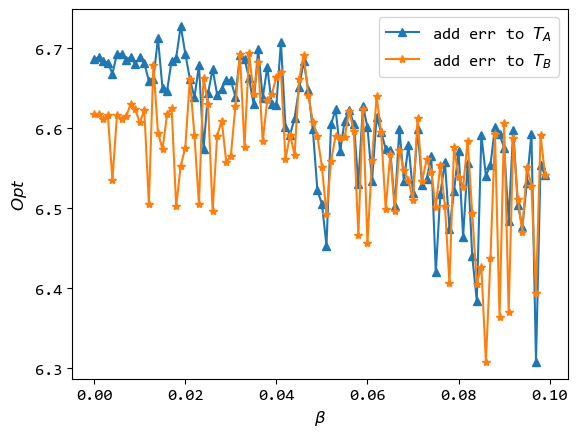

In [6]:
changeCostAopt

# 创建一个新的图形
plt.figure()
# 绘制第一个列表的折线图
plt.plot(np.arange(min_err, max_err, 0.001), changeCostAopt,'-^')
# 绘制第二个列表的折线图
plt.plot(np.arange(min_err, max_err, 0.001), changeCostBopt,'-*')
# 添加图例
plt.legend([r'add err to $T_A$',r'add err to $T_B$'])

# 添加坐标轴名称
plt.xlabel(r'$\beta$')
plt.ylabel(r'$Opt$')

plt.savefig('q2changeT.png', dpi=300)